# People Data Labs + Hamilton
This notebook will teach you how to use People Data Labs (PDL) [Company enrichment](https://docs.peopledatalabs.com/docs/company-enrichment-api) data along stock market data for financial analysis. We will introduce the Python library [Hamilon](https://hamilton.dagworks.io/en/latest/?badge=latest) to help create data transformations.

**Content**
1. Data preparation
2. Analytics: Explore the relationship between employee count and stock growth

## 0. Imports

In [1]:
import pandas as pd
from hamilton import driver
from IPython.display import display

# Loads a "jupyter magic" that allows special notebook interactions
%load_ext hamilton.plugins.jupyter_magic

## 1. Load raw data
Hamilton [uses Python functions to define a dataflow](https://hamilton.dagworks.io/en/latest/concepts/node/) of transformations. 

The next cell starts with the special statement `%%cell_to_module` and includes Python functions to define steps of our analysis. 

Executing the cell will produce a visualization of the flow of operations.

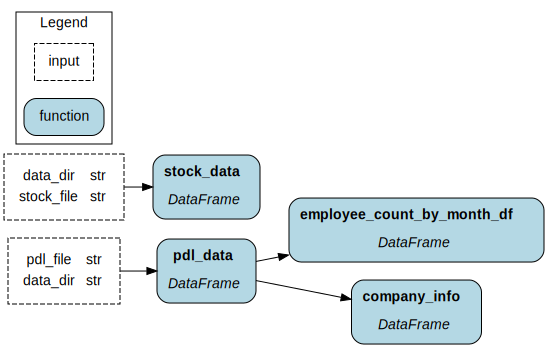

In [2]:
%%cell_to_module -m data_preparation -d

from pathlib import Path
import pandas as pd


def pdl_data(pdl_file: str, data_dir: str = "data/") -> pd.DataFrame:
    """Load raw Pêople Data Labs data stored locally"""
    return pd.read_json(Path(data_dir, pdl_file))


def stock_data(stock_file: str, data_dir: str = "data/") -> pd.DataFrame:
    """Load raw stock data stored locally"""
    return pd.read_json(Path(data_dir, stock_file))


def company_info(pdl_data: pd.DataFrame) -> pd.DataFrame:
    """Select columns containing general company info"""
    columns = [
        "id", "ticker", "website", "name", "display_name", "legal_name", "founded", 
        "industry", "type", "summary", "total_funding_raised", "latest_funding_stage",
        "number_funding_rounds", "last_funding_date", "inferred_revenue"
    ]
    return pdl_data[columns]


def employee_count_by_month_df(pdl_data: pd.DataFrame) -> pd.DataFrame:
    """Normalized employee count data"""
    return (
        pd.json_normalize(pdl_data["employee_count_by_month"])
        .assign(ticker=pdl_data["ticker"])
        .melt(
            id_vars="ticker",
            var_name="year_month",
            value_name="employee_count",
        )
        .astype({"year_month": "datetime64[ns]"})
    )

### Execute your first dataflow
This first cell creates a Hamilton `Driver` used to execute code. 

We pass it the `data_preparation` module define in the cell above (with `%%cell_to_module -m data_preparation`)

In [3]:
hamilton_driver = (
    driver.Builder()
    .with_modules(data_preparation)
    .build()
)

We specify the input values and the variables we want to compute.

In this case, we pass the path to the `pdl_file` and request `company_info`.

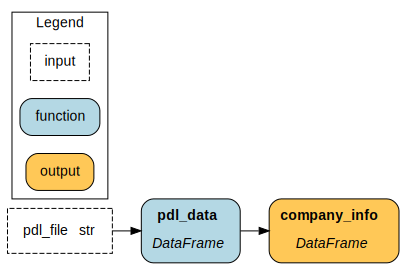

,id,ticker,website,name,display_name,legal_name,founded,industry,type,summary,total_funding_raised,latest_funding_stage,number_funding_rounds,last_funding_date,inferred_revenue
0,firstbankpr,FBP,1firstbank.com,firstbank,FirstBank,FIRST BANCORP,1948.0,banking,public,"backed by a history spanning over 70 years, fi...",NaN,None,NaN,None,$100M-$250M
1,motorolasolutions,MSI,motorolasolutions.com,motorola solutions,Motorola Solutions,"Motorola Solutions, Inc.",1928.0,telecommunications,public,motorola solutions is a global leader in publi...,1.000000e+09,post_ipo_equity,1.0,2023-01-06,$10B+
2,american-equity,AEL-PA,american-equity.com,american equity,American Equity,None,1995.0,insurance,public,american equity investment life insurance comp...,2.530000e+08,post_ipo_equity,2.0,2022-01-07,$250M-$500M


In [4]:
inputs = dict(pdl_file="pdl_data.json")

results = hamilton_driver.execute(["company_info"], inputs=inputs)

# `display()` can "print" multiple values for a single cell
# display the execution path and the result for `company_info`
display(
    hamilton_driver.visualize_execution(["company_info"], inputs=inputs),
    results["company_info"].head(3)
)

## 2. Analytics
We're interested in the potential relationship between employee count and stock growth in private companies (series A to D). 

We will need to:
- filter companies by funding stage
- define a window period since last funding round
- compute growth for employee count and stock

NOTE. We need to mention imports in each cell with `%%cell_to_module` (e.g., `import pandas as pd`) even if a package was imported previously.

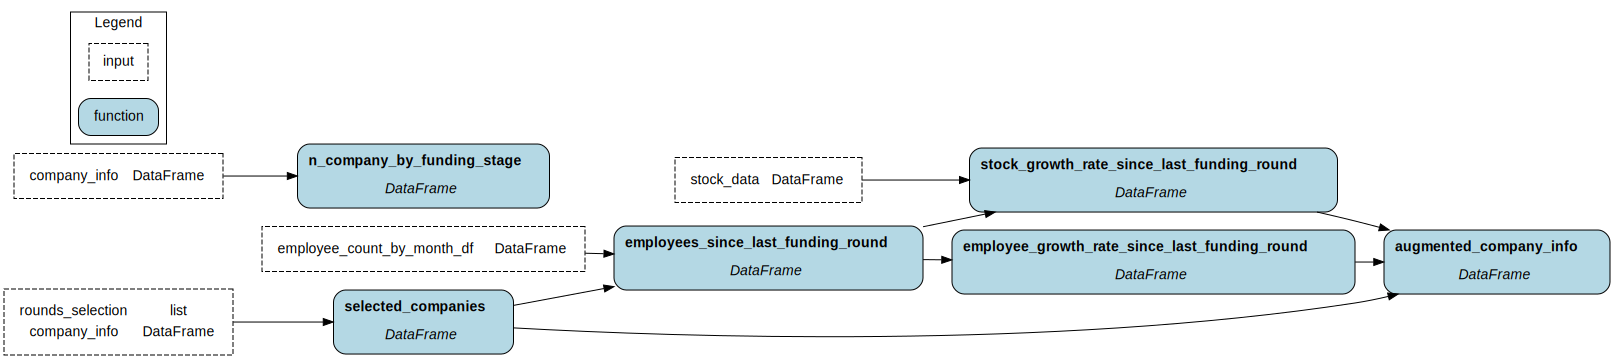

In [5]:
%%cell_to_module -m analytics -d

import pandas as pd


def n_company_by_funding_stage(company_info: pd.DataFrame) -> pd.DataFrame:
    """Get the number of company per funding stage"""
    return (
        company_info
        .groupby("latest_funding_stage")["latest_funding_stage"]
        .value_counts()
        .sort_values(ascending=False)
    )


def selected_companies(company_info: pd.DataFrame, rounds_selection: list[str]) -> pd.DataFrame:
    """Companies with `latest_funding_stage` included in `rounds_selection"""
    return company_info.loc[company_info.latest_funding_stage.isin(rounds_selection)]

       
def employees_since_last_funding_round(
    employee_count_by_month_df: pd.DataFrame,
    selected_companies: pd.DataFrame,
) -> pd.DataFrame:
    """Select employee count data since the last funding round"""
    employee_count_by_month_df = employee_count_by_month_df.loc[
        employee_count_by_month_df.ticker.isin(selected_companies.ticker)
    ]
    df = pd.merge(
        left=employee_count_by_month_df,
        right=selected_companies[["ticker", "last_funding_date"]],
        on="ticker",
        how="left"
    )
    return df.loc[df.year_month > df.last_funding_date]


def _growth_rate(group):
    """aggregation for growth rate; data needs to be sorted"""
    return (group.iloc[-1] - group.iloc[0]) / group.iloc[0]


def employee_growth_rate_since_last_funding_round(
    employees_since_last_funding_round: pd.DataFrame,
) -> pd.DataFrame:
    """Employee count growth rate since last funding round"""    
    return (
        employees_since_last_funding_round
        .sort_values(by="year_month", ascending=True)
        .groupby("ticker")["employee_count"]
        .aggregate(_growth_rate)
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"employee_count": "employee_growth"})
    )
    
    
def stock_growth_rate_since_last_funding_round(
    stock_data: pd.DataFrame,
    employees_since_last_funding_round: pd.DataFrame,
) -> pd.DataFrame:
    """Stock data since last funding round.
    Returns None is no stock history or window found.
    
    NOTE. We use the minimum date from the employee count history instead of the true
    funding round date to ensure growth rates cover the same period
    """
    period_start = (
        employees_since_last_funding_round
        .groupby("ticker")["year_month"]
        .min()
        .reset_index()
    )
    df = pd.merge(left=stock_data, right=period_start, on="ticker", how="inner")

    stock_growth = dict()
    for idx, row in df.iterrows():
        history = pd.json_normalize(row["historical_price"]).astype({"date": "datetime64[ns]"})
        
        # skip ticker if history is empty
        if history.empty:
            stock_growth[row.ticker] = None
            continue
        
        window = history[history.date > row.year_month]
        
        # skip ticker if window is empty
        if window.empty:
            stock_growth[row.ticker] = None
            continue
        
        stock_growth[row.ticker] = _growth_rate(window["close"])
        
    return (
        pd.DataFrame()
        .from_dict(stock_growth, orient="index")
        .reset_index()
        .rename(columns={"index": "ticker", 0: "stock_growth"})
    )
    
    
def augmented_company_info(
    selected_companies: pd.DataFrame,
    employee_growth_rate_since_last_funding_round: pd.DataFrame,
    stock_growth_rate_since_last_funding_round: pd.DataFrame,
) -> pd.DataFrame:
    """Merge employee count and stock growth with company info"""
    df = pd.merge(
        selected_companies,
        employee_growth_rate_since_last_funding_round,
        on="ticker",
        how="left",
    )
    df = pd.merge(
        df,
        stock_growth_rate_since_last_funding_round,
        on="ticker",
        how="left",
    )
    return df

### Execute the dataflow
We create another Driver to include the newly defined `analytics` module. 

Notice that the `Builder().with_modules()` can receive more than one module. Indeed, the visualization includes nodes both `data_preparation` and `analytics`.

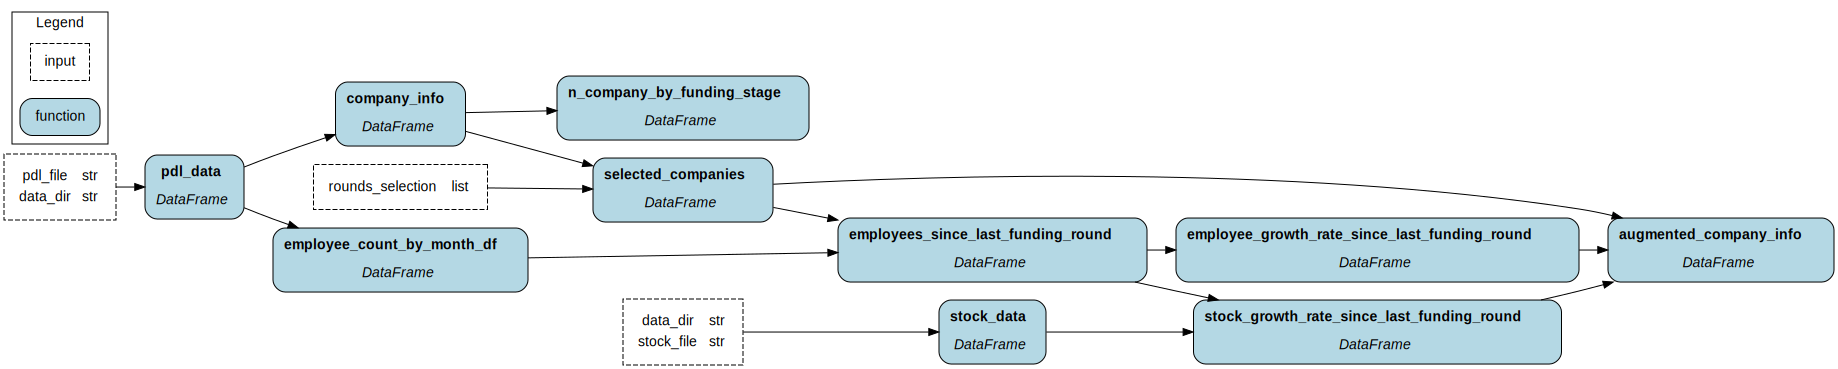

In [6]:
analytics_driver = (
    driver.Builder()
    .with_modules(data_preparation, analytics)
    .build()
)
analytics_driver

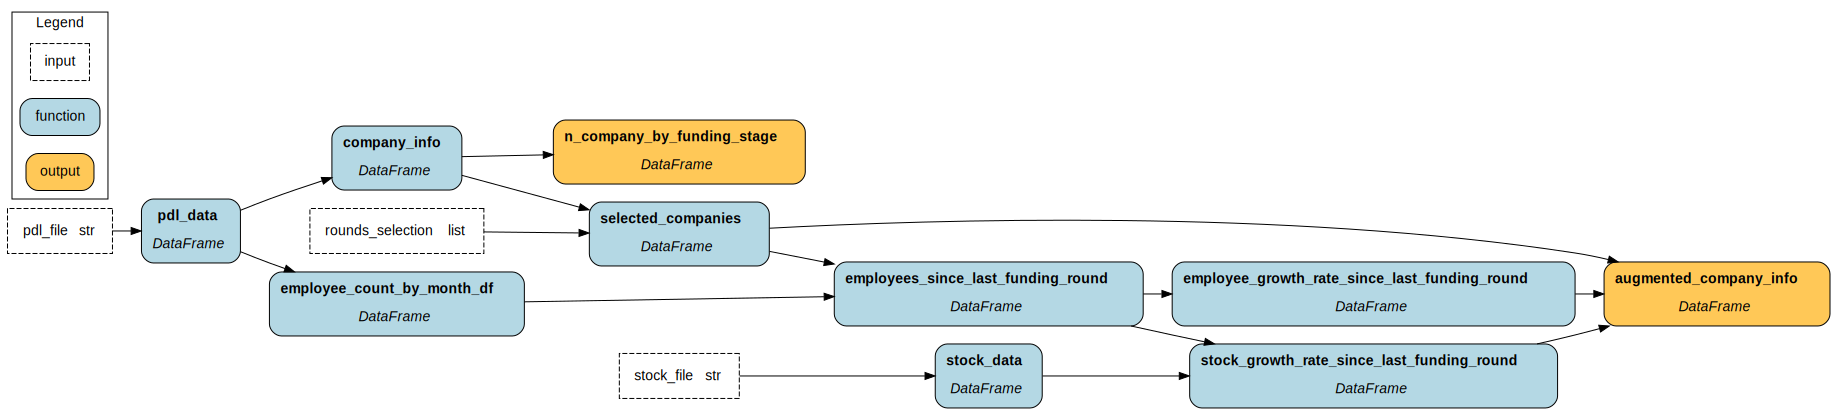

,id,ticker,website,name,display_name,legal_name,founded,industry,type,summary,total_funding_raised,latest_funding_stage,number_funding_rounds,last_funding_date,inferred_revenue,employee_growth,stock_growth
0,relxtech,RLX,relxtech.com,relx technology,Relx Technology,None,2018.0,consumer electronics,public,-,5.755918e+06,series_c,4.0,2019-08-15,$50M-$100M,0.552632,14.133333
1,beike,BEKE,ke.com,贝壳找房ke.com,贝壳找房ke.com,None,2018.0,real estate,public,beiker is a technology-driven new housing serv...,3.602538e+09,series_d,6.0,2020-03-05,$250M-$500M,0.112971,1.653437
2,upstart-network,UPST,upstart.com,upstart,Upstart,None,2012.0,financial services,public,"founded by ex-googlers, upstart is the first l...",1.440500e+08,series_d,7.0,2019-04-08,$500M-$1B,3.952218,0.220795
3,alarm-com,ALRM,alarm.com,alarm.com,Alarm.com,None,2000.0,information technology and services,public,alarm.com is the leading platform for the inte...,1.630000e+08,series_b,2.0,2012-07-24,$250M-$500M,7.906040,-0.154480
4,51talkhq,COE,51talk.com,51talk hq,51Talk HQ,None,2011.0,internet,public,"founded in 2011, headquartered in singapore, 5...",6.712601e+07,series_c,5.0,2014-10-23,$100M-$250M,3.103896,2.714286


In [7]:
inputs = dict(
    pdl_file="pdl_data.json",
    stock_file="stock_data.json",
    rounds_selection=["series_a", "series_b", "series_c", "series_d"]
)

final_vars = [
    "n_company_by_funding_stage",
    "augmented_company_info",
]

results = analytics_driver.execute(final_vars, inputs=inputs)

display(
    analytics_driver.visualize_execution(final_vars, inputs=inputs),
    results["augmented_company_info"].head(),
)

# Conclusion
Congrats! You concluded the introduction to People Data Labs + Hamilton!

You now know the basics of Hamilton and how it can help you define data transformations. If you haven't, visit the README of the repository to learn how to use Hamilton outside of notebooks.

### Resources
- [PDL Blog](https://blog.peopledatalabs.com/) and [PDL Recipes](https://docs.peopledatalabs.com/recipes)
- [Interactive Hamilton training](https://www.tryhamilton.dev/hamilton-basics/jumping-in)
- [Hamilton documentation](https://hamilton.dagworks.io/en/latest/concepts/node/)
- more [Hamilton code examples](https://github.com/DAGWorks-Inc/hamilton/tree/main/examples) and integrations with Python tools.